In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces
import torch as th

with open('../database/c_states_dict_v4.pkl', 'rb') as f:
    c_states = pickle.load(f)

print(c_states.keys())
print(c_states[5].shape)

dict_keys([5, 2.5, 0, -2.5, -5])
(2500, 18, 7, 120)


In [2]:
class FrequencyDetectionEnv(gym.Env):
    """Custom Environment for Frequency Objective Response Detection that follows gymnasium interface"""

    def __init__(self, data, initial_ep= 0):
        super(FrequencyDetectionEnv, self).__init__()

        self.data = data
        self.episodes = data.shape[0]-1
        self.frequencies = data.shape[1]-1
        self.measures = data.shape[2]
        self.windows = data.shape[3]-1
        self.current_episode = initial_ep
        self.current_window = 2
        self.current_frequency = 0

        # Action space: 0 (no detection) or 1 (detection)
        self.action_space = spaces.Discrete(2)

        # Observation space: 5 measures for each of the 4 frequencies (1 focus + 3 noise)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4*self.measures,), dtype=np.float32)

        # Initialize the internal state
        self.state = None
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0   
        self.tpr_hist = []
        self.fpr_hist = []
        self.latest_result = {'tp_rate':np.nan,'fp_rate':np.nan}

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns the initial observation."""
        super().reset(seed=seed)
        
        if  self.current_episode< self.episodes:
            self.current_episode +=1
        else:
            self.current_episode = np.random.randint(0, self.episodes)

        self.current_window = 2
        self.current_frequency = 0
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0        
         
        self.tpr_hist = []
        self.fpr_hist = []
        
        # Initialize the state
        self.state = self._get_state(self.current_frequency, self.current_window)
        return self.state, self.latest_result

    def _get_state(self, frequency, window, episode= 0):
        """Helper function to get the state at a given frequency and window."""
         
        if episode != 0:
            self.current_episode = episode

        focus_measure = self.data[self.current_episode, frequency, :, window]
        
        # Select 3 random noise frequencies, excluding the current focus frequency
        noise_indices = np.setdiff1d(np.arange(9, 17), frequency - 9 if frequency >= 9 else [])
        noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        noise_measures = [self.data[self.current_episode, nf, :, window] for nf in noise_frequencies]
         
        measures = np.concatenate(([focus_measure], noise_measures), axis=0).flatten()

        return np.array(measures, dtype=np.float32)

    def step(self, action, episode = -1):
        """Executes one time step within the environment."""
        # Returns:
        # tuple (observation, reward, terminated, truncated, info).
        # Return type:
        # Tuple[Tuple | Dict[str, Any] | ndarray | int, float, bool, bool, Dict]
        
        if episode != -1:
            self.current_episode = episode

        reward = 0
        kp_fp = 1
        fp_des = 0.05
        
        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        self.current_frequency += 1
        window_done = self.current_frequency >= self.frequencies
        epsiode_terminated = self.current_window >= self.windows
        info = {'tp_rate':np.nan,'fp_rate':np.nan}

        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)

            current_ep_prog = 100
            
            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)
                
            reward = +( -(((100-fp_des)**2)/100 +(fp_des**2)/-100) +((self.fp_rate)**2)/(-100)+ ((self.tp_rate)**2)/(100) )*current_ep_prog/100
            
            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            if not(epsiode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if epsiode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)
            current_ep_prog =100

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            reward = +( -(((100-fp_des)**2)/100+(fp_des**2)/-100)
                    +(kp_fp*(np.round(np.mean(self.fpr_hist),4))**2)/(-100)
                    +((np.round(np.mean(self.tpr_hist),4))**2)/(100))*current_ep_prog/100
           
            truncated = False

            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2)}
            self.latest_result = info

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 1
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 1
                else:
                    tn = 1

            reward = tp-kp_fp*fp-fn+tn

            truncated = False

        return self.state, reward, epsiode_terminated, truncated, info
    def render(self, mode='human'):
        """Render the environment for visualization purposes."""
        if mode=='human':
            print(f'Window: {self.current_window}, Frequency: {self.current_frequency},TP: {self.tp_rate}, FP: {self.fp_rate}')

    def close(self):
        """Clean up any resources used by the environment."""
        pass

# First step

In [3]:
snr_treino = 0
data = c_states[snr_treino]
timesteps = (120-2)*(18-1)*1
print(f'Total decisions: {timesteps}')
print(data.shape[2]+1)

Total decisions: 2006
8


In [4]:
env = FrequencyDetectionEnv(data)
model_ppo = PPO('MlpPolicy', env, verbose=1
            ,policy_kwargs=dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi =[data.shape[2]+1], vf=[data.shape[2]+1]))
                )
model_ppo.learn(total_timesteps=timesteps)
model_ppo.save('conv_mini_ppo_snr5.zip')
_, latest = env.reset()
print(latest)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.99e+03 |
|    ep_rew_mean     | -69.4    |
| time/              |          |
|    fps             | 1413     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
{'tp_rate': 55.46, 'fp_rate': 48.24, 'episode': {'r': -69.415185, 'l': 1990, 't': 2.564199}, 'TimeLimit.truncated': False, 'terminal_observation': array([-1.5031338e+00, -2.8798234e-01, -1.2326915e+00,  1.0000000e+02,
        9.9952259e+00,  3.1681894e+01,  2.7032475e+00, -1.2743454e+00,
       -2.3003931e-01, -1.3976852e+00,  1.0000000e+02,  5.9226494e+00,
        1.2191598e+01, -8.8377766e-02, -1.2743454e+00, -2.3003931e-01,
       -1.3976852e+00,  1.0000000e+02,  5.9226494e+00,  1.2191598e+01,
       -8.8377766e-02, -4.2095280e+00, -2.9415518e-01, -3.648981

In [5]:
env = FrequencyDetectionEnv(data)
_,_ =env.reset()
model_dqn = DQN('MlpPolicy', env, verbose=1
            ,policy_kwargs=dict(activation_fn=th.nn.ReLU,net_arch=[data.shape[2]+1])
                )
model_dqn.learn(total_timesteps=timesteps)
model_dqn.save('conv_mini_dqn_snr5.zip')
_, latest = env.reset()
print(latest)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
{'tp_rate': 78.06, 'fp_rate': 72.84, 'episode': {'r': -79.018076, 'l': 1990, 't': 2.201113}, 'TimeLimit.truncated': False, 'terminal_observation': array([ -0.10442115,  -0.10078265,  -0.16086137, 100.        ,
        -0.419904  ,  65.53174   ,   0.31593457,  -1.2692637 ,
        -0.2811983 ,  -1.0954133 , 100.        ,   7.2598352 ,
        10.337519  ,  -0.7109995 ,  -2.002803  ,  -0.2738264 ,
        -2.2568002 , 100.        ,   9.131565  ,   9.721592  ,
        -2.7202246 ,  -1.454451  ,  -0.29919058,  -1.9685118 ,
       100.        ,   5.8431897 ,   9.382199  ,  -0.15453416],
      dtype=float32)}


In [6]:
env = FrequencyDetectionEnv(data)
_,_ =env.reset()
model_a2c = A2C('MlpPolicy', env, verbose=1
            ,policy_kwargs=dict(activation_fn=th.nn.ReLU,net_arch=[data.shape[2]+1])
            )
model_a2c.learn(total_timesteps=timesteps)
model_a2c.save('conv_mini_a2c_snr5.zip')
_, latest = env.reset()
print(latest)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 479      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.589   |
|    explained_variance | -15.1    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.25     |
|    value_loss         | 10.1     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 489      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.349   |
|    explained_variance | 0.416    |
|    learning_rate      | 0.0007   |
|    n_updates    

# Convergence evaluation once

In [7]:
def my_evaluate_model(model_path, model_class, env, num_episodes=10,model_name = 'ppo'):
    tpr_hist = []
    fpr_hist = []
    rewards = []

    for episode in range(num_episodes):
        obs,_ = env.reset()
        model = model_class.load(model_path, env = env)
        done = False
        total_reward = 0
        tpr_episode = []
        fpr_episode = []
        ep = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            # bs, reward, terminated, truncated, info 
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            if not np.isnan(info['tp_rate']):
                tpr_episode.append(info['tp_rate'])
                fpr_episode.append(info['fp_rate'])

                done = True

        tpr_hist.append(np.mean(tpr_episode))
        fpr_hist.append(np.mean(fpr_episode))
        rewards.append(total_reward)

    return tpr_hist, fpr_hist, rewards

In [8]:
with open('../database/c_states_dict_acer_2.pkl', 'rb') as f:
    c_states_teste = pickle.load(f)

print(c_states_teste.keys())
c_states_teste= c_states_teste[snr_treino]
print(c_states_teste.shape)

dict_keys([5, 0, -5, -10, -15, -20, -25])
(2500, 18, 7, 120)


In [9]:
test_env = FrequencyDetectionEnv(c_states_teste)

tpr_hist, fpr_hist, rewards = my_evaluate_model('conv_mini_ppo_snr5.zip', PPO, test_env)
print(np.mean(tpr_hist))
print(np.mean(fpr_hist))


tpr_hist, fpr_hist, rewards = my_evaluate_model('conv_mini_dqn_snr5.zip', DQN, test_env)
print(np.mean(tpr_hist))
print(np.mean(fpr_hist))

tpr_hist, fpr_hist, rewards = my_evaluate_model('conv_mini_a2c_snr5.zip', A2C, test_env)
print(np.mean(tpr_hist))
print(np.mean(fpr_hist))

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
89.4
77.123
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a 

# Convergence demonstration

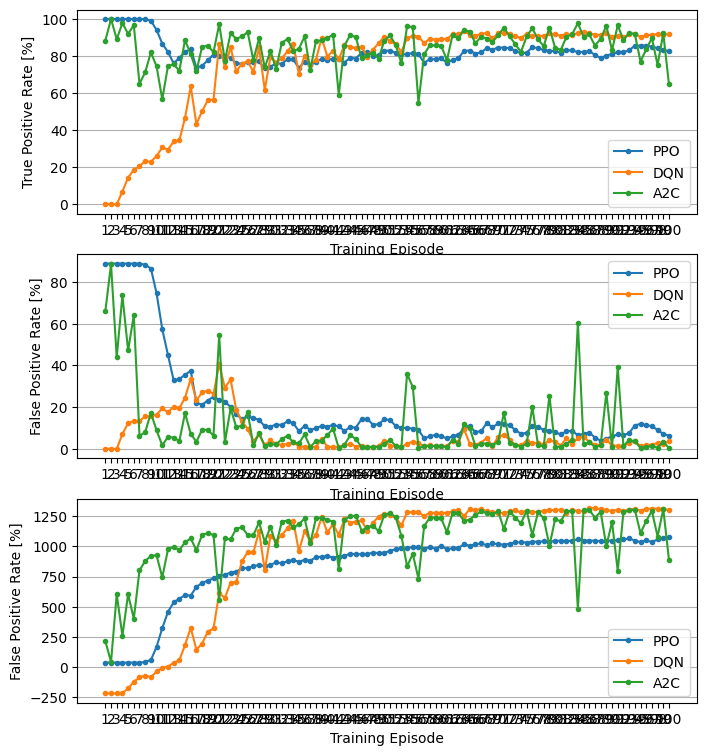

In [16]:
conv_dict = dict()
num_eps = 100
for episode in range(1,num_eps+1):

    # Learn
    if episode == 1:
        learn_env = FrequencyDetectionEnv(data, initial_ep=episode)
        model = PPO('MlpPolicy', learn_env, verbose=0,policy_kwargs=dict(activation_fn=th.nn.ReLU,net_arch=dict(pi =[data.shape[2]+1], vf=[data.shape[2]+1])))
        model.learn(total_timesteps=timesteps)
        model.save('conv_mini_ppo_snr5.zip')

        learn_env = FrequencyDetectionEnv(data, initial_ep=episode)
        model = DQN('MlpPolicy', env, verbose=0,policy_kwargs=dict(activation_fn=th.nn.ReLU,net_arch=[data.shape[2]+1]))
        model.learn(total_timesteps=timesteps)
        model.save('conv_mini_dqn_snr5.zip')

        learn_env = FrequencyDetectionEnv(data, initial_ep=episode)
        model_a2c = A2C('MlpPolicy', env, verbose=0,policy_kwargs=dict(activation_fn=th.nn.ReLU,net_arch=[data.shape[2]+1]))
        model_a2c.learn(total_timesteps=timesteps)
        model_a2c.save('conv_mini_a2c_snr5.zip')
        
    else:
        learn_env = FrequencyDetectionEnv(data, initial_ep=episode)
        model = PPO.load('conv_mini_ppo_snr5.zip', env = learn_env, verbose=False)
        model.learn(total_timesteps=timesteps)    
        model.save('conv_mini_ppo_snr5.zip')

        learn_env = FrequencyDetectionEnv(data, initial_ep=episode)
        model = DQN.load('conv_mini_dqn_snr5.zip', env = learn_env, verbose=False)
        model.learn(total_timesteps=timesteps)    
        model.save('conv_mini_dqn_snr5.zip')

        learn_env = FrequencyDetectionEnv(data, initial_ep=episode)
        model = A2C.load('conv_mini_a2c_snr5.zip', env = learn_env, verbose=False)
        model.learn(total_timesteps=timesteps)    
        model.save('conv_mini_a2c_snr5.zip')

    # Test
    test_env = FrequencyDetectionEnv(c_states_teste)

    tpr_hist_ppo, fpr_hist_ppo, rew_hist_ppo = my_evaluate_model('conv_mini_ppo_snr5.zip', PPO, test_env, num_episodes=10)
    tpr_hist_dqn, fpr_hist_dqn, rew_hist_dqn = my_evaluate_model('conv_mini_dqn_snr5.zip', DQN, test_env, num_episodes=10)
    tpr_hist_a2c, fpr_hist_a2c, rew_hist_a2c = my_evaluate_model('conv_mini_a2c_snr5.zip', A2C, test_env, num_episodes=10)

    conv_dict[episode] = {
        'TPR':{
            'PPO':tpr_hist_ppo,
            'DQN':tpr_hist_dqn,
            'A2C':tpr_hist_a2c
        },
        'FPR':{
            'PPO':fpr_hist_ppo,
            'DQN':fpr_hist_dqn,
            'A2C':fpr_hist_a2c
        },
        'REW':{
            'PPO':rew_hist_ppo,
            'DQN':rew_hist_dqn,
            'A2C':rew_hist_a2c
        }
    }

def get_res_avg(conv_dict, metric, model):
    res = []
    for ep in conv_dict.keys():
        res.append(np.mean(conv_dict[ep][metric][model]))
    return res


episodes = np.arange(1,num_eps+1,step=1)
# plt.figure(figsize=(16,4))
plt.figure(figsize=(8,9))
plt.subplot(311)
plt.plot(episodes, get_res_avg(conv_dict, 'TPR','PPO'), label = 'PPO', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'TPR','DQN'), label = 'DQN', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'TPR','A2C'), label = 'A2C', marker = '.')
plt.ylabel('True Positive Rate [%]')
plt.xlabel('Training Episode')
plt.xticks(episodes)
plt.gca().yaxis.grid()
plt.legend()

plt.subplot(312)
plt.plot(episodes, get_res_avg(conv_dict, 'FPR','PPO'), label = 'PPO', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'FPR','DQN'), label = 'DQN', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'FPR','A2C'), label = 'A2C', marker = '.')
plt.ylabel('False Positive Rate [%]')
plt.xlabel('Training Episode')
plt.xticks(episodes)
plt.gca().yaxis.grid()
plt.legend()

plt.subplot(313)
plt.plot(episodes, get_res_avg(conv_dict, 'REW','PPO'), label = 'PPO', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'REW','DQN'), label = 'DQN', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'REW','A2C'), label = 'A2C', marker = '.')
plt.ylabel('False Positive Rate [%]')
plt.xlabel('Training Episode')
plt.xticks(episodes)
plt.gca().yaxis.grid()
plt.legend()

plt.show()

In [17]:
import pickle

with open('../database/convergence_demo.pkl', 'wb') as f:
    pickle.dump(conv_dict, f)

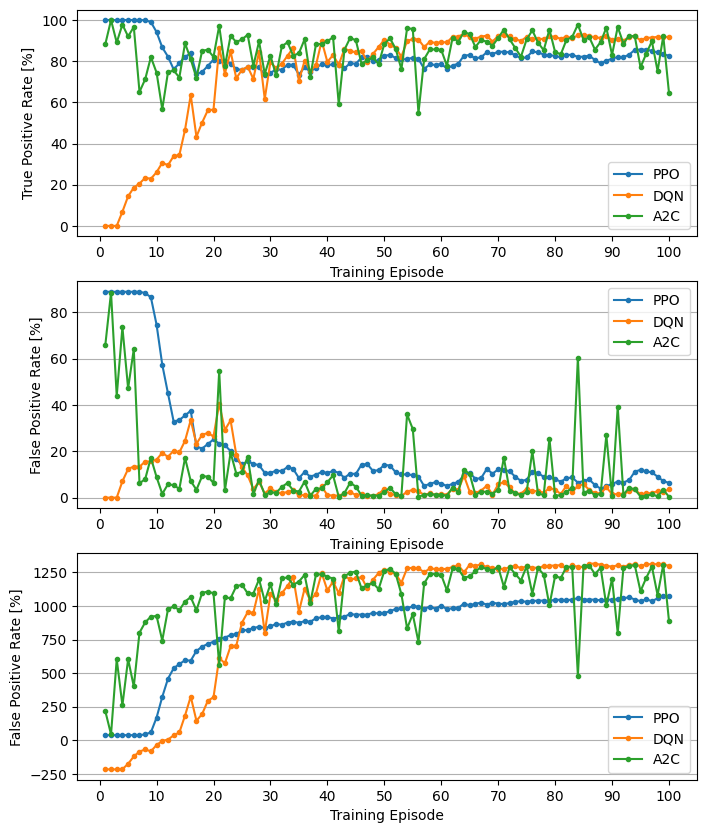

In [25]:
episodes = np.arange(1,num_eps+1,step=1)
# plt.figure(figsize=(16,4))
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(episodes, get_res_avg(conv_dict, 'TPR','PPO'), label = 'PPO', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'TPR','DQN'), label = 'DQN', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'TPR','A2C'), label = 'A2C', marker = '.')
plt.ylabel('True Positive Rate [%]')
plt.xlabel('Training Episode')
plt.xticks( np.arange(0,num_eps+10,step=10))
plt.gca().yaxis.grid()
plt.legend()

plt.subplot(312)
plt.plot(episodes, get_res_avg(conv_dict, 'FPR','PPO'), label = 'PPO', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'FPR','DQN'), label = 'DQN', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'FPR','A2C'), label = 'A2C', marker = '.')
plt.ylabel('False Positive Rate [%]')
plt.xlabel('Training Episode')
plt.xticks( np.arange(0,num_eps+10,step=10))
plt.gca().yaxis.grid()
plt.legend()

plt.subplot(313)
plt.plot(episodes, get_res_avg(conv_dict, 'REW','PPO'), label = 'PPO', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'REW','DQN'), label = 'DQN', marker = '.')
plt.plot(episodes, get_res_avg(conv_dict, 'REW','A2C'), label = 'A2C', marker = '.')
plt.ylabel('False Positive Rate [%]')
plt.xlabel('Training Episode')
plt.xticks( np.arange(0,num_eps+10,step=10))
plt.gca().yaxis.grid()
plt.legend()

plt.show()